In [0]:
import torch
import numpy as np
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [30]:
num_workers = 0
batch_size=32
valid_size=0.2
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
train_data = datasets.CIFAR10('data',train=True,download=True,transform=transform)
test_data = datasets.CIFAR10('data',train=False,download=True,transform=transform)

num_train=len(train_data)
indices=list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(image):
  image= image/2 +0.5
  plt.imshow(np.transpose(image, (1, 2, 0)))

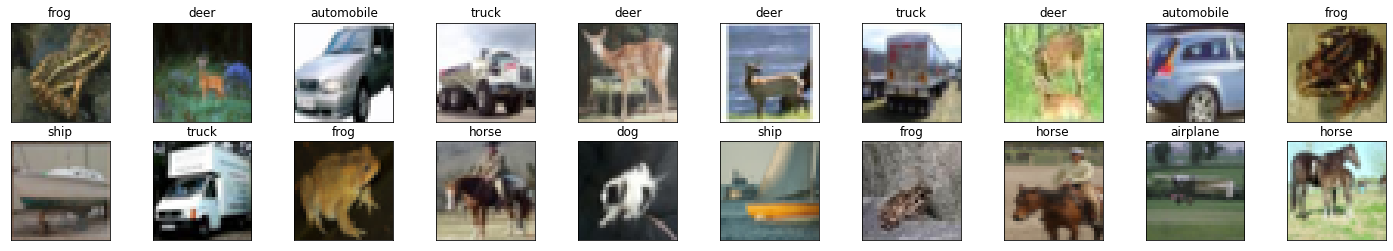

In [32]:
dataiter = iter(train_loader)
images,labels=dataiter.next()
images=images.numpy()

fig=plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1=nn.Conv2d(3,316,3,padding=1)
    self.conv2=nn.Conv2d(16,32,3,padding=1)
    self.conv3=nn.Conv2d(32,64,3,padding=1)
    self.conv4=nn.Conv2d(64,128,3,padding=1)
    
    self.pool = nn.MaxPool2d(2,2)

    self.fc1=nn.Linear(128*2*2,500)
    self.fc2=nn.Linear(500,10)

    self.dropout=nn.Dropout(0.25)


  def forward(x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    x=self.pool(F.relu(self.conv4(x)))

    x=x.view(-1, 128 * 2 * 2)

    x=self.dropout(F.relu(self.fc1(x)))
    x=self.fc2(x)

    return x



In [34]:
model = Net()
print(model)
train_on_gpu=torch.cuda.is_available()
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 316, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

